# Erase Operator

In this example we demonstrate the capabilities of the `Erase` operator and the different ways to specify its arguments.

The `Erase` operator can be used to remove parts of a tensor (for example, an image) by specifying one or more regions with a value to fill the erased regions.

1. Define a DALI pipeline that we will be using to demonstrate the different use cases.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import matplotlib.pyplot as plt

batch_size = 1
image_filename = "../data/images"


def erase_pipeline(
    anchor,
    shape,
    axis_names,
    fill_value=0,
    normalized_anchor=False,
    normalized_shape=False,
    centered_anchor=False,
):
    pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=0)
    with pipe:
        jpegs, _ = fn.readers.file(device="cpu", file_root=image_filename)
        images = fn.decoders.image(jpegs, device="cpu", output_type=types.RGB)
        erased = fn.erase(
            images,
            device="cpu",
            anchor=anchor,
            shape=shape,
            axis_names=axis_names,
            fill_value=fill_value,
            normalized_anchor=normalized_anchor,
            normalized_shape=normalized_shape,
            centered_anchor=centered_anchor,
        )
        pipe.set_outputs(erased)

    return pipe

2. Write a simple utility function to run and display the output of a pipeline instance

In [2]:
def show(pipe):
    pipe.build()
    out = pipe.run()
    plt.imshow(out[0].at(0))

3. We can now use the pipeline to demonstrate the different use cases of the erase operator.

4. Specify a rectangular region with an anchor and a rectangular shape that is specified with absolute coordinates.

The order of the axes in the `anchor` and `shape` arguments is described by the `axis_names` argument. The specified axis names also need to be present in the layout of the input. For instance, `layout="HWC"` and `axis_names="HW"` is equal to saying that the first coordinate corresponds to the axis with an index of 0, and the second coordinate corresponds to the axis with an index of 1. Alternatively, you can specify the `axes` argument with a list of axis indexes, for example `axes=(0, 1)`.

**Note**: Using `axis_names` is preferred over `axes`.

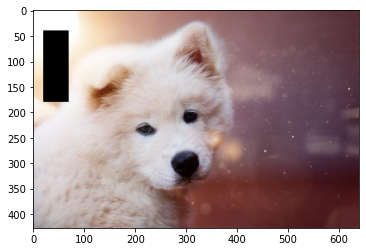

In [3]:
show(erase_pipeline(anchor=(40, 20), shape=(140, 50), axis_names="HW"))

5. If we change the `axis_names` value, the same region arguments might be interpreted differently. 

   For example, `layout="HWC"` and `axis_names="WH"` means that the first coordinate refers to the axis with an index of 1 and the second coordinate corresponds to the axis with an index of 0.

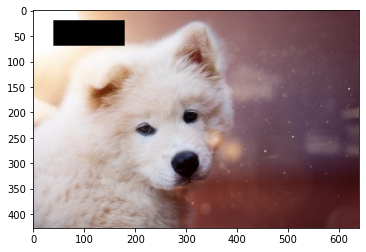

In [4]:
show(erase_pipeline(anchor=(40, 20), shape=(140, 50), axis_names="WH"))

6. Specify a vertical or horizontal stripe by specifying only one dimension

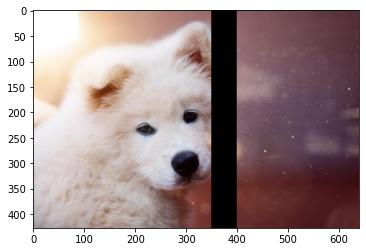

In [5]:
show(erase_pipeline(anchor=(350), shape=(50), axis_names="W"))

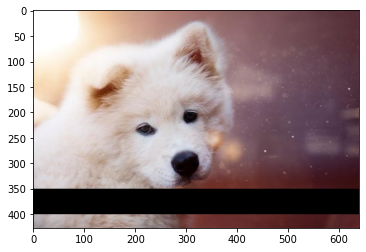

In [6]:
show(erase_pipeline(anchor=(350), shape=(50), axis_names="H"))

7. Specify multiple regions by adding more points to the `anchor` and `shape` arguments. 

For instance, an `anchor` and `shape` with 4 points and the argument `axis_names="HW"` representing 2 axes is interpreted as the following regions:

- `anchor=(y0, x0, y1, x1)`

- `shape=(h0, w0, h1, w1)`

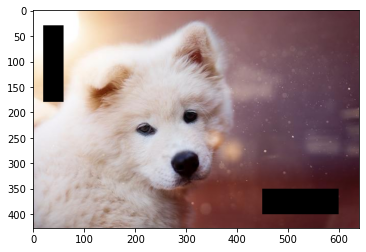

In [7]:
show(erase_pipeline(anchor=(30, 20, 350, 450), shape=(150, 40, 50, 150), axis_names="HW"))

Similarly, an `anchor` and `shape` with 3 elements representing only one axis (`axis_names="W"`), corresponds to the following regions:

 - `anchor=(x0, x1, x2)`
  
 - `shape=(w0, w1, w2)`

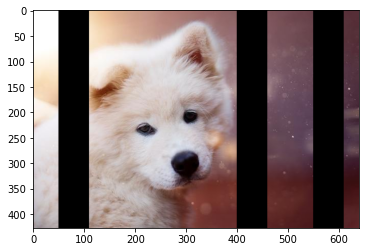

In [8]:
show(erase_pipeline(anchor=(50, 400, 550), shape=(60, 60, 60), axis_names="W"))

8. We can also change the default value for the erased regions. If one `fill_value` is provided, it is used in all the channels.

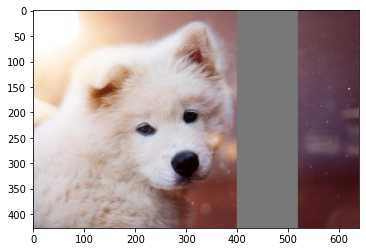

In [9]:
show(erase_pipeline(anchor=(400), shape=(120), axis_names="W", fill_value=120))

9. Alternatively, we can specify a multi-channel fill value, for example `fill_value=(118, 185, 0)`. 

   In this case, the input layout needs to contain the `C` channel, for example `"HWC"`. 

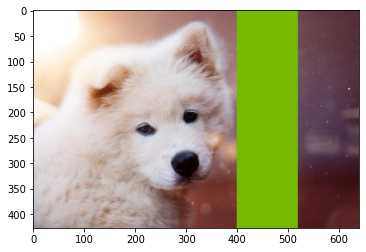

In [10]:
show(erase_pipeline(anchor=(400), shape=(120), axis_names="W", fill_value=(118, 185, 0)))

Regions that fall totally, or partially out of the bounds of the image are ignored or trimmed respectively. 

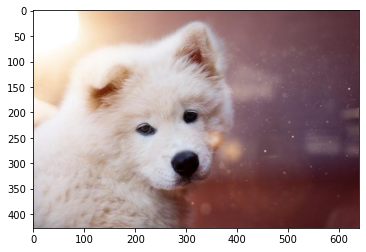

In [11]:
show(erase_pipeline(anchor=(800), shape=(120), axis_names="W", fill_value=(118, 185, 0)))

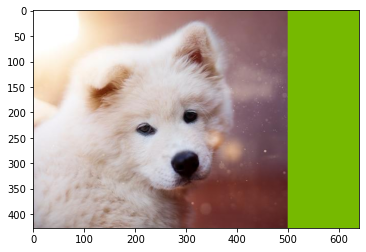

In [12]:
show(erase_pipeline(anchor=(500), shape=(500), axis_names="W", fill_value=(118, 185, 0)))

The region coordinates can also be specified by relative coordinates. In this case, to obtain the absolute coordinates, the relative coordinates are multiplied by the input dimensions.

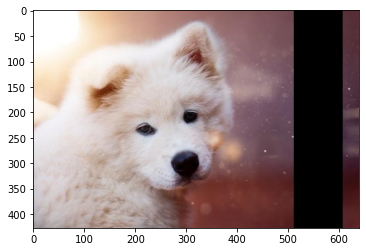

In [13]:
show(
    erase_pipeline(
        anchor=(0.8), shape=(0.15), axis_names="W", normalized_anchor=True, normalized_shape=True
    )
)

You can use relative and absolute coordinates to independently specify `anchor` and `shape`.

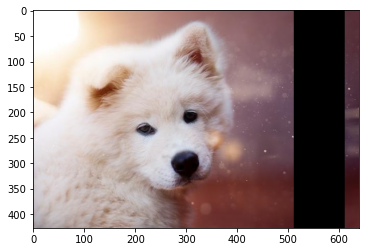

In [14]:
show(
    erase_pipeline(
        anchor=(0.8), shape=(100), axis_names="W", normalized_anchor=True, normalized_shape=False
    )
)

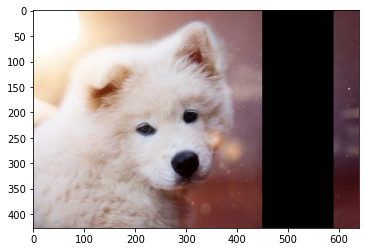

In [15]:
show(
    erase_pipeline(
        anchor=(450), shape=(0.22), axis_names="W", normalized_anchor=False, normalized_shape=True
    )
)

10. Specify that the regions should be centered at a specified `anchor`, instead of starting at it.

    For this, we can use the `centered_anchor` boolean argument.

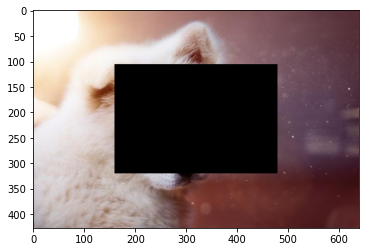

In [16]:
show(
    erase_pipeline(
        anchor=(0.5, 0.5),
        shape=(0.5, 0.5),
        axis_names="HW",
        centered_anchor=True,
        normalized_anchor=True,
        normalized_shape=True,
    )
)

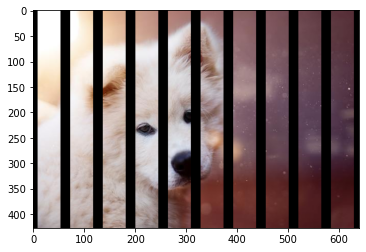

In [17]:
anchor = [k / 10 for k in range(11)]
shape = [0.03] * 11
show(
    erase_pipeline(
        anchor=anchor,
        shape=shape,
        axis_names="W",
        centered_anchor=True,
        normalized_anchor=True,
        normalized_shape=True,
    )
)

10. Use tensor inputs, to specify the regions. 

    For instance, we can use the output of a random number generator to feed the `anchor` and `shape` arguments of the `Erase` operator.

In [18]:
def random_erase_pipeline(axis_names="W", nregions=5):
    pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=0)
    with pipe:
        jpegs, _ = fn.readers.file(device="cpu", file_root=image_filename)
        images = fn.decoders.image(jpegs, device="cpu", output_type=types.RGB)
        ndims = len(axis_names)
        args_shape = (ndims * nregions,)
        random_anchor = fn.random.uniform(range=(0.0, 1.0), shape=args_shape)
        random_shape = fn.random.uniform(range=(20.0, 50), shape=args_shape)
        erased = fn.erase(
            images,
            device="cpu",
            anchor=random_anchor,
            shape=random_shape,
            axis_names=axis_names,
            fill_value=(118, 185, 0),
            normalized_anchor=True,
            normalized_shape=False,
        )
        pipe.set_outputs(erased)

    return pipe

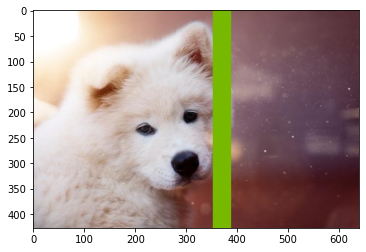

In [19]:
show(random_erase_pipeline(axis_names="W", nregions=1))

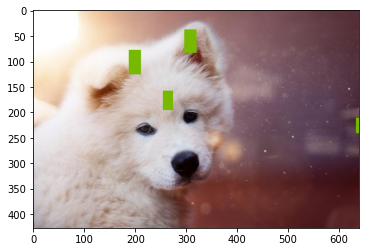

In [20]:
show(random_erase_pipeline(axis_names="WH", nregions=4))

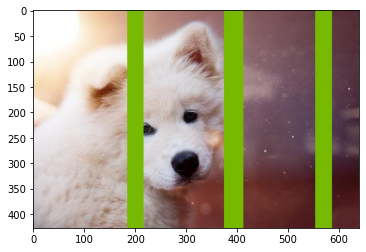

In [21]:
show(random_erase_pipeline(axis_names="W", nregions=3))